# LLM - Detect AI Generated Text
## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords

from gensim.corpora import Dictionary
from gensim.models import word2vec
from gensim.models import doc2vec

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast

import keras

[nltk_data] Downloading package punkt to /home/mrtc101/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtc101/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-08 11:58:16.764360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:58:16.764426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already be

### Inferred Features

In [2]:
def features(dataset):
    token_count=dataset["text"].apply(lambda x: len(x))
    sentence_count = []
    punctuation_count = []
    apostrofees_count = []
    unk_count = []
    for doc in dataset["text"]:
        unk = 0
        dot = 0
        punctuation = 0
        apostrofees = 0
        for token in doc:
            if(token.endswith(".")):
                dot+=1
                punctuation+=1
            elif(token.endswith(",") or token.endswith("?") or token.endswith("!")):
                punctuation+=1
            elif(token.count("'")>0):
                    apostrofees+=token.count("'")
            elif(token=="[UNK]"):
                unk+=1
        sentence_count.append(dot)
        punctuation_count.append(punctuation)
        apostrofees_count.append(apostrofees)
        unk_count.append(unk)
    df = pd.DataFrame(
        columns=["token_num","sent_num","punct_sym","apostrof_sym","unk_num"]
    )
    df["token_num"]=token_count
    df["sent_num"]=sentence_count
    df["punct_sym"]=punctuation_count
    df["apostrof_sym"]=apostrofees_count
    df["unk_num"]=unk_count
    return df

In [3]:
test_dataset = pd.read_csv("../data/test_essays.csv")
tokenizer = PreTrainedTokenizerFast.from_pretrained("../data/weight/preTrainedTokenizer/")
doc_model = doc2vec.Doc2Vec.load("../data/weight/EmbeddingModel.bin")
model = keras.models.load_model("../data/weight/DenseNetwork.h5")

## Tokenizing

In [4]:
#load tokenizer
tokenized_test = test_dataset;
tokenized_test["text"] = test_dataset["text"].apply(lambda x : tokenizer.tokenize(text=x))

## Embedding

In [79]:
#load embeddings model
embeddings_matrix = [doc_model.infer_vector(tokenList,epochs=400) for tokenList in tokenized_test["text"]]
embeddings_test_dataset = pd.DataFrame(embeddings_matrix)
embeddings_test_dataset

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.323233,0.573526,-0.482229,1.492072,0.769350,0.052134,3.177414,3.354922,-1.979838,0.310579,...,-0.280734,-0.411301,0.935737,1.760192,1.199909,0.608611,-1.317225,-2.866957,2.637788,-1.017730
1,0.246005,-0.423801,-0.930756,0.359568,0.233403,-0.297046,1.316551,1.963103,-1.954452,0.564944,...,-0.390843,0.798971,1.607709,1.490006,1.490089,0.320282,-1.254535,-1.908998,2.102362,-1.050684
2,-0.932014,0.312867,-0.991497,0.156486,0.082016,-0.536992,1.252609,1.938345,-1.290655,0.544613,...,0.053625,1.065181,1.697251,1.333253,1.271291,-0.864076,-1.633081,-2.200127,1.141523,-0.218486


#### Normalizado de embedding

In [80]:
embeddings_test_dataset["norm"]=np.linalg.norm(embeddings_test_dataset, axis=1)
norm_embeddings_test_dataset = pd.DataFrame(np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=1, arr=embeddings_test_dataset))
norm_embeddings_test_dataset["normalized_norm"] = (embeddings_test_dataset['norm'] - embeddings_test_dataset['norm'].min()) / (embeddings_test_dataset['norm'].max() - embeddings_test_dataset['norm'].min())
norm_embeddings_test_dataset = norm_embeddings_test_dataset.drop([100],axis=1)
pre_processed_test_data = pd.concat([tokenized_test,norm_embeddings_test_dataset],axis=1)
pre_processed_test_data

,id,prompt_id,text,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,normalized_norm
0,0000aaaa,2,"[Ġaaa, Ġb, b, b, Ġc, cc, .]",0.017882,0.031728,-0.026678,0.082544,0.042562,0.002884,0.175779,...,-0.022754,0.051766,0.097376,0.066381,0.033669,-0.072871,-0.158604,0.145926,-0.056302,1.000000
1,1111bbbb,3,"[Ġb, b, b, Ġc, cc, Ġd, dd, .]",0.019482,-0.033563,-0.073712,0.028476,0.018484,-0.023525,0.104265,...,0.063275,0.127323,0.118002,0.118008,0.025365,-0.099354,-0.151184,0.166498,-0.083209,0.082828
2,2222cccc,4,"[Ġc, cc, Ġd, dd, Ġe, ee, .]",-0.076805,0.025782,-0.081706,0.012896,0.006759,-0.044252,0.103224,...,0.087778,0.139866,0.109869,0.104763,-0.071206,-0.134577,-0.181306,0.094070,-0.018005,0.000000


## Feature inferring

In [81]:
test_features = features(pre_processed_test_data)
for col in test_features.columns:
    if(test_features[col].max()>0):
        test_features[col] = test_features[col] / np.linalg.norm(test_features[col])
pre_processed_test_data=pd.concat([pre_processed_test_data,test_features],axis=1).drop("text",axis=1)

In [82]:
pre_processed_test_data

,id,prompt_id,0,1,2,3,4,5,6,7,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,0000aaaa,2,0.017882,0.031728,-0.026678,0.082544,0.042562,0.002884,0.175779,0.185599,...,-0.072871,-0.158604,0.145926,-0.056302,1.000000,0.549972,0.57735,0.57735,0,0
1,1111bbbb,3,0.019482,-0.033563,-0.073712,0.028476,0.018484,-0.023525,0.104265,0.155469,...,-0.099354,-0.151184,0.166498,-0.083209,0.082828,0.628539,0.57735,0.57735,0,0
2,2222cccc,4,-0.076805,0.025782,-0.081706,0.012896,0.006759,-0.044252,0.103224,0.159733,...,-0.134577,-0.181306,0.094070,-0.018005,0.000000,0.549972,0.57735,0.57735,0,0


## Model prediction

### Dense Neural Network

In [83]:
#load model
X_test = pre_processed_test_data.drop(["id"],axis=1)
pred = model.predict(x=X_test)

1/1 [==============================] - 0s 22ms/step


In [84]:
submition = pd.DataFrame()
submition["id"]=pre_processed_test_data["id"].to_numpy()
submition["generated"] = pred.round(4)
submition

,id,generated
0,0000aaaa,1.0
1,1111bbbb,0.0
2,2222cccc,0.0


In [85]:
submition.to_csv("../data/submission.csv",index=False)

## Plot inference of embedding

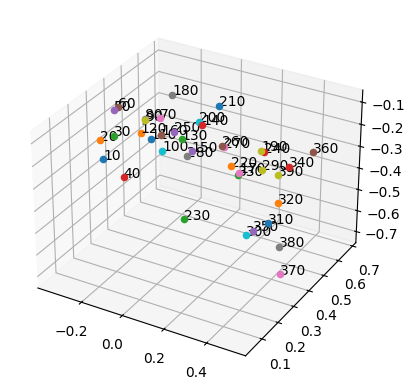

In [86]:
ax = plt.axes(projection='3d')

for i in range(10,400,10):
    v = doc_model.infer_vector(tokenized_test["text"][0],epochs=i)
    ax.scatter3D(v[0],v[1],v[2])
    ax.text3D(v[0],v[1],v[2],s=i)